In [178]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
import random

from datasets import DataImageNet 

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
# download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# don't train the model
for param in model.parameters():
    param.requires_grad = False

# print model info
# print(model)

Data information:
Training data shape:  (25, 3, 224, 224)
Training labels shape:  (25,)

Some examples:


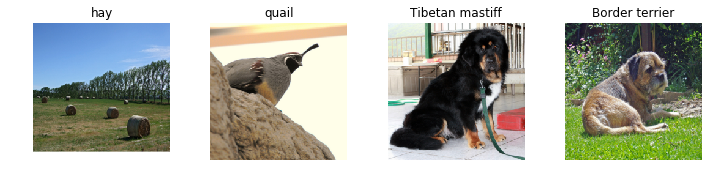

In [166]:
# data loader
data_loader = DataImageNet('./datasets/imagenet_val_25/')

# show info
print('Data information:')
data_loader.show_info()

# show some image
print('\nSome examples:')
data_loader.show_by_data(data_loader.x_train[0: 4], data_loader.y_train[0: 4])

In [212]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(xs):
    mean = SQUEEZENET_MEAN.reshape([1, 3, 1, 1])
    std = SQUEEZENET_STD.reshape([1, 3, 1, 1])
    xs = (xs - mean) / std
    return xs

def deprocess(xs, should_rescale=True):
    mean = SQUEEZENET_MEAN.reshape([1, 3, 1, 1])
    std = SQUEEZENET_STD.reshape([1, 3, 1, 1])
    xs = xs * std + mean
    if should_rescale:
        for i in range(len(xs)):
            xs[i] = rescale(xs[i])
    return xs

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

# Saliency Maps

In [171]:
def compute_saliency_map(x, y, model):
    # change model to 'test' mode
    model.eval()
    
    # the gradients to compute
    x.requires_grad_()
    
    # model
    scores = model(x)
    scores = scores.gather(1, y.view(-1, 1)).squeeze()
    loss = scores.sum()
    
    # backpropagate
    loss.backward()
    
    # saliency map
    saliency, _ = torch.max(torch.abs(x.grad), 1)
    
    # return
    return saliency

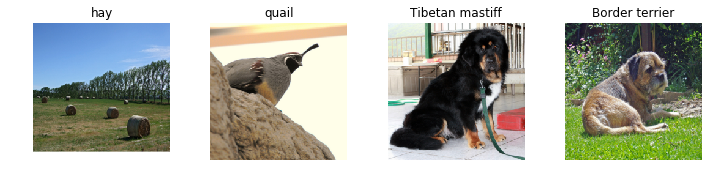

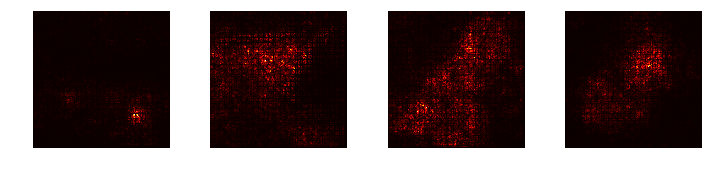

In [180]:
# get data
x = data_loader.x_train[0: 4]
y = data_loader.y_train[0: 4]

# preprocess and to Torch Tensors
x_tensor = torch.FloatTensor(preprocess(x))
y_tensor = torch.LongTensor(y)

# compute saliency map
saliency = compute_saliency_map(x_tensor, y_tensor, model)
saliency = saliency.numpy()

# show results
data_loader.show_by_data(x, y)
data_loader.show_by_data(saliency, None, cmap=plt.cm.hot)

# Fooling Images

In [200]:
def make_fooling_image(x, target_y, model):
    # hyperparameters
    learning_rate = 0.01
    ite_max = 50
    
    # change model to 'test' mode
    model.eval()
    
    # the gradients to compute
    x_fooling = x.clone()
    x_fooling.requires_grad_()
    
    ite_num = 1
    while True:
        # model
        scores = model(x_fooling)
        scores = scores[:, target_y]
        loss = scores.sum()

        # backpropagate
        loss.backward()

        # update - fast gradient sign method（FGSM）
        fgs = x_fooling.grad.clone()
        fgs[fgs > 0] = 1
        fgs[fgs < 0] = -1
        x_fooling.data += learning_rate * fgs
        
        # update - gradient ascend
        # x_fooling.data += learning_rate * x_fooling.grad / x_fooling.grad.norm()

        # zero gradient
        x_fooling.grad.zero_()
        
        # check whether fooling succeed
        scores = model(x_fooling)
        _, y_fooling = torch.max(scores, 1)
        if (y_fooling == target_y).all() or ite_num >= ite_max:
            break
        else:
            ite_num += 1
    
    # return
    return x_fooling.data, ite_num

In [207]:
# get data
x = data_loader.x_train[0: 4]
y = data_loader.y_train[0: 4]
target_y = 8

# deprocess and to Torch Tensor
x_tensor = torch.FloatTensor(preprocess(x))

# make fooling images
x_tensor_fool, ite_num = make_fooling_image(x_tensor, target_y, model)

# check fooling labels
scores = model(x_tensor_fool)
_, y_tensor_fool = torch.max(scores, 1)

# deprocess and to Numpy Array
x_fool = deprocess(x_tensor_fool.numpy())
y_fool = y_tensor_fool.numpy()

# show results - labels
print('Afer', ite_num, 'iteration:')
print('Original labels are', y)
print('Fooling labels are', y_fool)

Afer 8 iteration:
Original labels are [958  85 244 182]
Fooling labels are [8 8 8 8]


Original images:


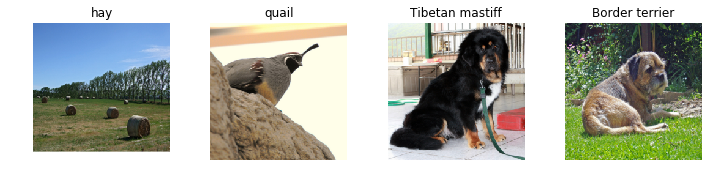

Fooling images:


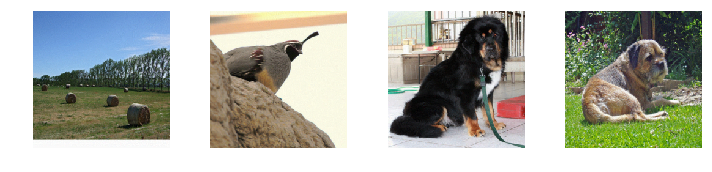

Diff images:


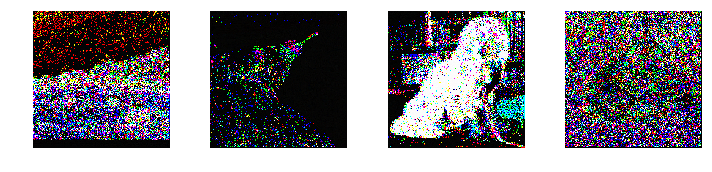

In [208]:
# show results - images
print('Original images:')
data_loader.show_by_data(x[0: 4], y[0: 4])
print('Fooling images:')
data_loader.show_by_data(x_fool[0: 4], None)
print('Diff images:')
data_loader.show_by_data((x - x_fool)[0: 4], None)

# Class visualization

In [214]:
def blur_image(X, sigma=1):
    X_np = X.clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    # X.copy_(torch.Tensor(X_np).type_as(X))
    return torch.Tensor(X_np)


def jitter_image(X, ox, oy):
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X


def create_class_visualization(target_y, model, img_num=3):
    # hyperparameters
    ite_num = 100
    l2_reg = 1e-3
    learn_rate = 25
    blur_every = 10
    max_jitter = 16
    
    # change model to 'test' mode
    model.eval()
    
    # the gradients to compute
    img = torch.randn(img_num, 3, 224, 224)
    img.requires_grad_()
    
    for t in range(ite_num):
        # randomly jitter the image
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data = jitter_image(img.data, ox, oy)
        
        # model
        scores = model(img)
        scores = scores[:, target_y]
        loss = scores.sum() - l2_reg * img.norm() ** 2

        # backpropagate
        loss.backward()
        
        # update
        img.data += learn_rate * img.grad
        
        # zero gradient
        img.grad.zero_()
        
        # undo the random jitter
        img.data = jitter_image(img.data, -ox, -oy)

        # as regularizer, clamp the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
            
        # as regularizer, periodically blur the image
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
    # return
    return img.data

Label name: gorilla, Gorilla gorilla


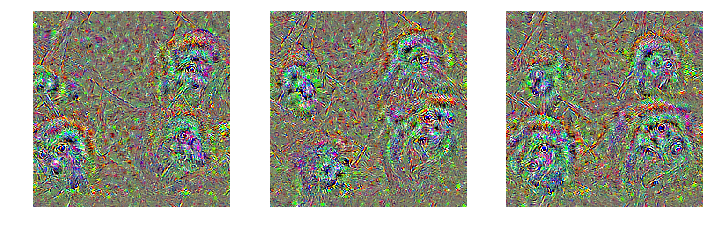

In [215]:
# target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
target_y = 366 # Gorilla
# target_y = 604 # Hourglass

# class visualization
img = create_class_visualization(target_y, model)
img = deprocess(img.numpy())

# show results
print('Label name:', data_loader.label_names[target_y])
data_loader.show_by_data(img, None)